In [1]:
import networkx as nx
from pymongo import MongoClient
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch
from torch.nn.functional import relu
import pickle
import numpy as np
from scipy.sparse import csr_matrix
from collections import deque
import pandas as pd
import os
from functools import partial
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
conn = MongoClient()

process_fibvid = conn.process_fibvid
tweets_tokens = process_fibvid.tweets_tokens
tweets_bert = process_fibvid.tweets_bert_fast

In [3]:
def tweets_relation(edge_data, relation):
    if relation in edge_data:
        relation_date = f'{relation}_date'
        return [t for t in zip(edge_data[relation], edge_data[relation_date])]
    return []


def invert_graph(graph):
    n_graph = nx.DiGraph()
    for node in graph.nodes:
        n_graph.add_node(node, **graph.nodes[node])
    for edge in graph.edges:
        n_graph.add_edge(*edge[::-1], **graph.edges[edge])
    return n_graph


def create_adyacency_matrix(graph, add_self_relation=True):
    nodes = list(graph.nodes)
    nodes.sort()
    nodes_id = {v: i for i, v in enumerate(nodes)}
    edges = set()
    for n in nodes:
        node_id = nodes_id[n]
        if add_self_relation:
            edges.add((node_id, node_id))
        for _, t in graph.edges(n):
            edges.add((node_id, nodes_id[t]))
    row, col = tuple(zip(*edges))
    row = np.asarray(row, dtype=np.int32)
    col = np.asarray(col, dtype=np.int32)
    data = np.ones_like(row)
    return csr_matrix((data, (row, col)), shape=(len(nodes), len(nodes))), nodes_id


def normalized_adyacency(a):
    d = (np.array(a.sum(axis=1)) ** (-1/2)).flatten()
    d = csr_matrix((d, (np.arange(d.shape[0]), np.arange(d.shape[0]))), shape=a.shape)
    return d @ a @ d


def depth_subgrap(graph, start, max_depth):
    to_process = deque()
    to_process.append((start, 0))
    added = set()
    nodes = list()
    while len(to_process) != 0:
        val = to_process.popleft()
        if val[0] not in added:
            node, depth = val
            added.add(node)
            #nodes.append(val)
            nodes.append(node)
            if depth < max_depth:
                for _, next_node in graph.edges(node):
                    to_process.append((next_node, depth + 1))
    return nodes


class UserDataset(Dataset):
    
    def __init__(self, user_graph, tweet_graph, users, user_features, inverted_graph=True, 
                 max_depth_user=1, max_depth_tweet=1, max_tweets=None, threshold=0.5):
        self.user_graph = user_graph
        self.tweet_graph = tweet_graph
        self.user_features = user_features
        self.users = list(users)
        self.users.sort()
        self.user_tweets = {}
        self._init_tweets()
        if inverted_graph:
            self.user_graph = invert_graph(user_graph)
            self.tweet_graph = invert_graph(tweet_graph)
        self.a_user, self.user_idx = create_adyacency_matrix(self.user_graph)
        self.a_tweet, self.tweet_idx = create_adyacency_matrix(self.tweet_graph)
        self.dad_user = normalized_adyacency(self.a_user)
        self.dad_tweet = normalized_adyacency(self.a_tweet)
        self.max_depth_user = max_depth_user
        self.max_depth_tweet = max_depth_tweet
        self.max_tweets = max_tweets
        self.threshold = threshold
        pass
    
    def _init_tweets(self):
        print('Int tweets')
        for u in tqdm(self.users):
            #Tweets que no generan relación
            if 'tweets' in self.user_graph.nodes[u]:
                tweets = list(self.user_graph.nodes[u]['tweets'])
            else:
                tweets = []
            #Tweets que generan relación
            for e in self.user_graph.edges(u):
                edge_data = self.user_graph.edges[e]
                replies = tweets_relation(edge_data, 'replies')
                mentions = tweets_relation(edge_data, 'mentions')
                parent = tweets_relation(edge_data, 'parent')
                full = replies + mentions + parent
            rels = set()
            for t in full:
                if t[0] not in rels:
                    tweets.append(t)
                    rels.add(t[0])
            tweets.sort(key=lambda x:x[1], reverse=True)
            tweets = [x[0] for x in tweets]
            self.user_tweets[u] = tweets
        pass 
    
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        #Users
        user = self.users[idx]
        #Get the subgraph for the user up to max_depth_users elementens
        users = depth_subgrap(self.user_graph, user, self.max_depth_user)
        users_ids = np.asarray([self.user_idx[u] for u in users])
        #Gets for each user in the neigborhood its neigbors
        #with is values in an array like row-wide, and then reshape
        #it as an adjacency matrix. For instance, if the users are 1, 3 , 4, 
        #it gets self.dad_user[[1 1 1 3 3 3 4 4 4], [1 3 4 1 3 4 1 3 4]]
        d_user = self.dad_user[users_ids.repeat(users_ids.shape[0]), 
                               np.hstack([users_ids] * users_ids.shape[0])]
        d_user = np.array(d_user).reshape((users_ids.shape[0], users_ids.shape[0]))
        #Tweets
        tweets = self.user_tweets[user] if self.max_tweets is None else self.user_tweets[user][:self.max_tweets]
        full_tweets = list(tweets)
        added_tweets = set(full_tweets)
        for t in tweets:
            next_tweets = depth_subgrap(self.tweet_graph, t, self.max_depth_tweet)
            for nt in next_tweets:
                if nt not in added_tweets:
                    added_tweets.add(nt)
                    full_tweets.append(nt)
        #Similar for the tweets-graph (it might be refactored into a single methos)
        full_tweets_id = np.asarray([self.tweet_idx[u] for u in full_tweets]) 
        d_tweet = self.dad_tweet[full_tweets_id.repeat(full_tweets_id.shape[0]),
                                 np.hstack([full_tweets_id] * full_tweets_id.shape[0])]
        d_tweet = np.array(d_tweet).reshape((full_tweets_id.shape[0], full_tweets_id.shape[0]))
        #Getting tweets
        pos_tweets = {t: i for i, t in enumerate(full_tweets)}
        bert_tweet = np.zeros((len(full_tweets), 768))
        for tweet_data in tweets_bert.find({'tweetId': {'$in': [int(x) for x in full_tweets]}}):
            bert = np.array(tweet_data['pooler_output'])
            bert_tweet[pos_tweets[tweet_data['tweetId']], :] = bert
        '''
        bert_data = {}
        max_len = 0
        for tweet_data in tweets_bert.find({'tweetId': {'$in': [int(x) for x in full_tweets]}}):
            bert = np.array(tweet_data['pooler_output'])
            #Esto es si va con tokens
            #if max_len < bert.shape[0]:
            #    max_len = bert.shape[0]
            bert_data[pos_tweets[tweet_data['tweetId']]] = bert
        bert_tweet = np.zeros((len(full_tweets), 768))
        for p, data in bert_data.values():
            bert_tweet[p, :] = bert
        '''
        #Feature 
        user_features = self.user_features.loc[users].values
        #label
        label = 1 if self.user_graph.nodes[user]['score_graph'] > self.threshold else -1
        return {'user_graph': d_user, 'users':users, 'user_features': user_features, 
                'tweets': full_tweets, 'user_tweets': tweets, 'tweet_graph': d_tweet,
                'tweet_bert': bert_tweet, 'label': label}

In [4]:
def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
train_graph = load_pickle('data/gg_users_full.gpickle')
tweet_graph = load_pickle('data/gg_tweets_full.gpickle')
user_features = pd.read_pickle('data/profile_features/fibvid_features_all_features.pickle')
user_partitions = load_pickle('data/users_profile_split_temporal.pickle')

In [6]:
def merge_dataset_instances(batch, user_features=len(user_features.columns)):
    #user part
    user_size = max([d['user_features'].shape[0] for d in batch])
    user_features = np.zeros((len(batch), user_size, user_features), dtype=np.float32)
    user_graph = np.zeros((len(batch), user_size, user_size), dtype=np.float32)
    #bert part
    tweet_sizes = [len(d['user_tweets']) for d in batch]
    tweet_size = max([d['tweet_bert'].shape[0] for d in batch])   
    tweet_features = np.zeros((len(batch), tweet_size, 768), dtype=np.float32)
    tweet_graph = np.zeros((len(batch), tweet_size, tweet_size), dtype=np.float32)
    #data copy
    labels = np.zeros((len(batch), 1), dtype=np.float32)
    for i, d in enumerate(batch):
        #user data copy
        c_user_features = d['user_features']
        c_user_graph = d['user_graph']
        user_features[i, :c_user_features.shape[0], :] = c_user_features
        user_graph[i, :c_user_graph.shape[0], :c_user_graph.shape[0]] = c_user_graph
        #tweet data copy
        c_tweet_bert = d['tweet_bert']
        c_tweet_graph = d['tweet_graph']
        tweet_features[i, :c_tweet_bert.shape[0], :] = c_tweet_bert
        tweet_graph[i, :c_tweet_graph.shape[0], :c_tweet_graph.shape[0]] = c_tweet_graph
        #labels
        labels[i, 0] = d['label']
    #Pasando a torch
    user_features = torch.from_numpy(user_features)
    user_graph = torch.from_numpy(user_graph)
    tweet_features = torch.from_numpy(tweet_features)
    tweet_graph = torch.from_numpy(tweet_graph)
    #labels
    labels = torch.from_numpy(labels) 
    return {'user_features': user_features, 'user_graph': user_graph, 
            'tweet_bert': tweet_features, 'tweet_graph': tweet_graph,
           'tweet_len': tweet_sizes}, labels

# Modelo base

A partir de este momento va el modelo. Lo primero es la capa GCN 

$$ GCN(X, G) = GXW+b $$

La capa asume que G es la representación del grado calculada a partir de la matriz de adjacenca $A$

$$ G = \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}} $$

Donde:

$$ \hat{A} = A + I $$

y 

$$ D_{i,i} = \sum{j}{A_{i,j}} $$

$$ D_{i,j} = 0  | \forall i, j: i \ne j $$

In [7]:
import torch
from torch.nn.parameter import Parameter

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, units, use_bias=True):
        super().__init__()
        kernel = torch.empty((input_size, units), dtype=torch.float32)
        torch.nn.init.xavier_uniform_(kernel)
        self.kernel = Parameter(kernel)
        self.user_bias = use_bias
        if use_bias:
            bias = torch.zeros((units,), dtype=torch.float32)
            self.bias = Parameter(bias)

    def forward(self, x, a):
        partial = x @ self.kernel
        partial = a @ partial
        if self.user_bias:
            partial += self.bias
        return partial

## Modulo que sigue el gráfico

![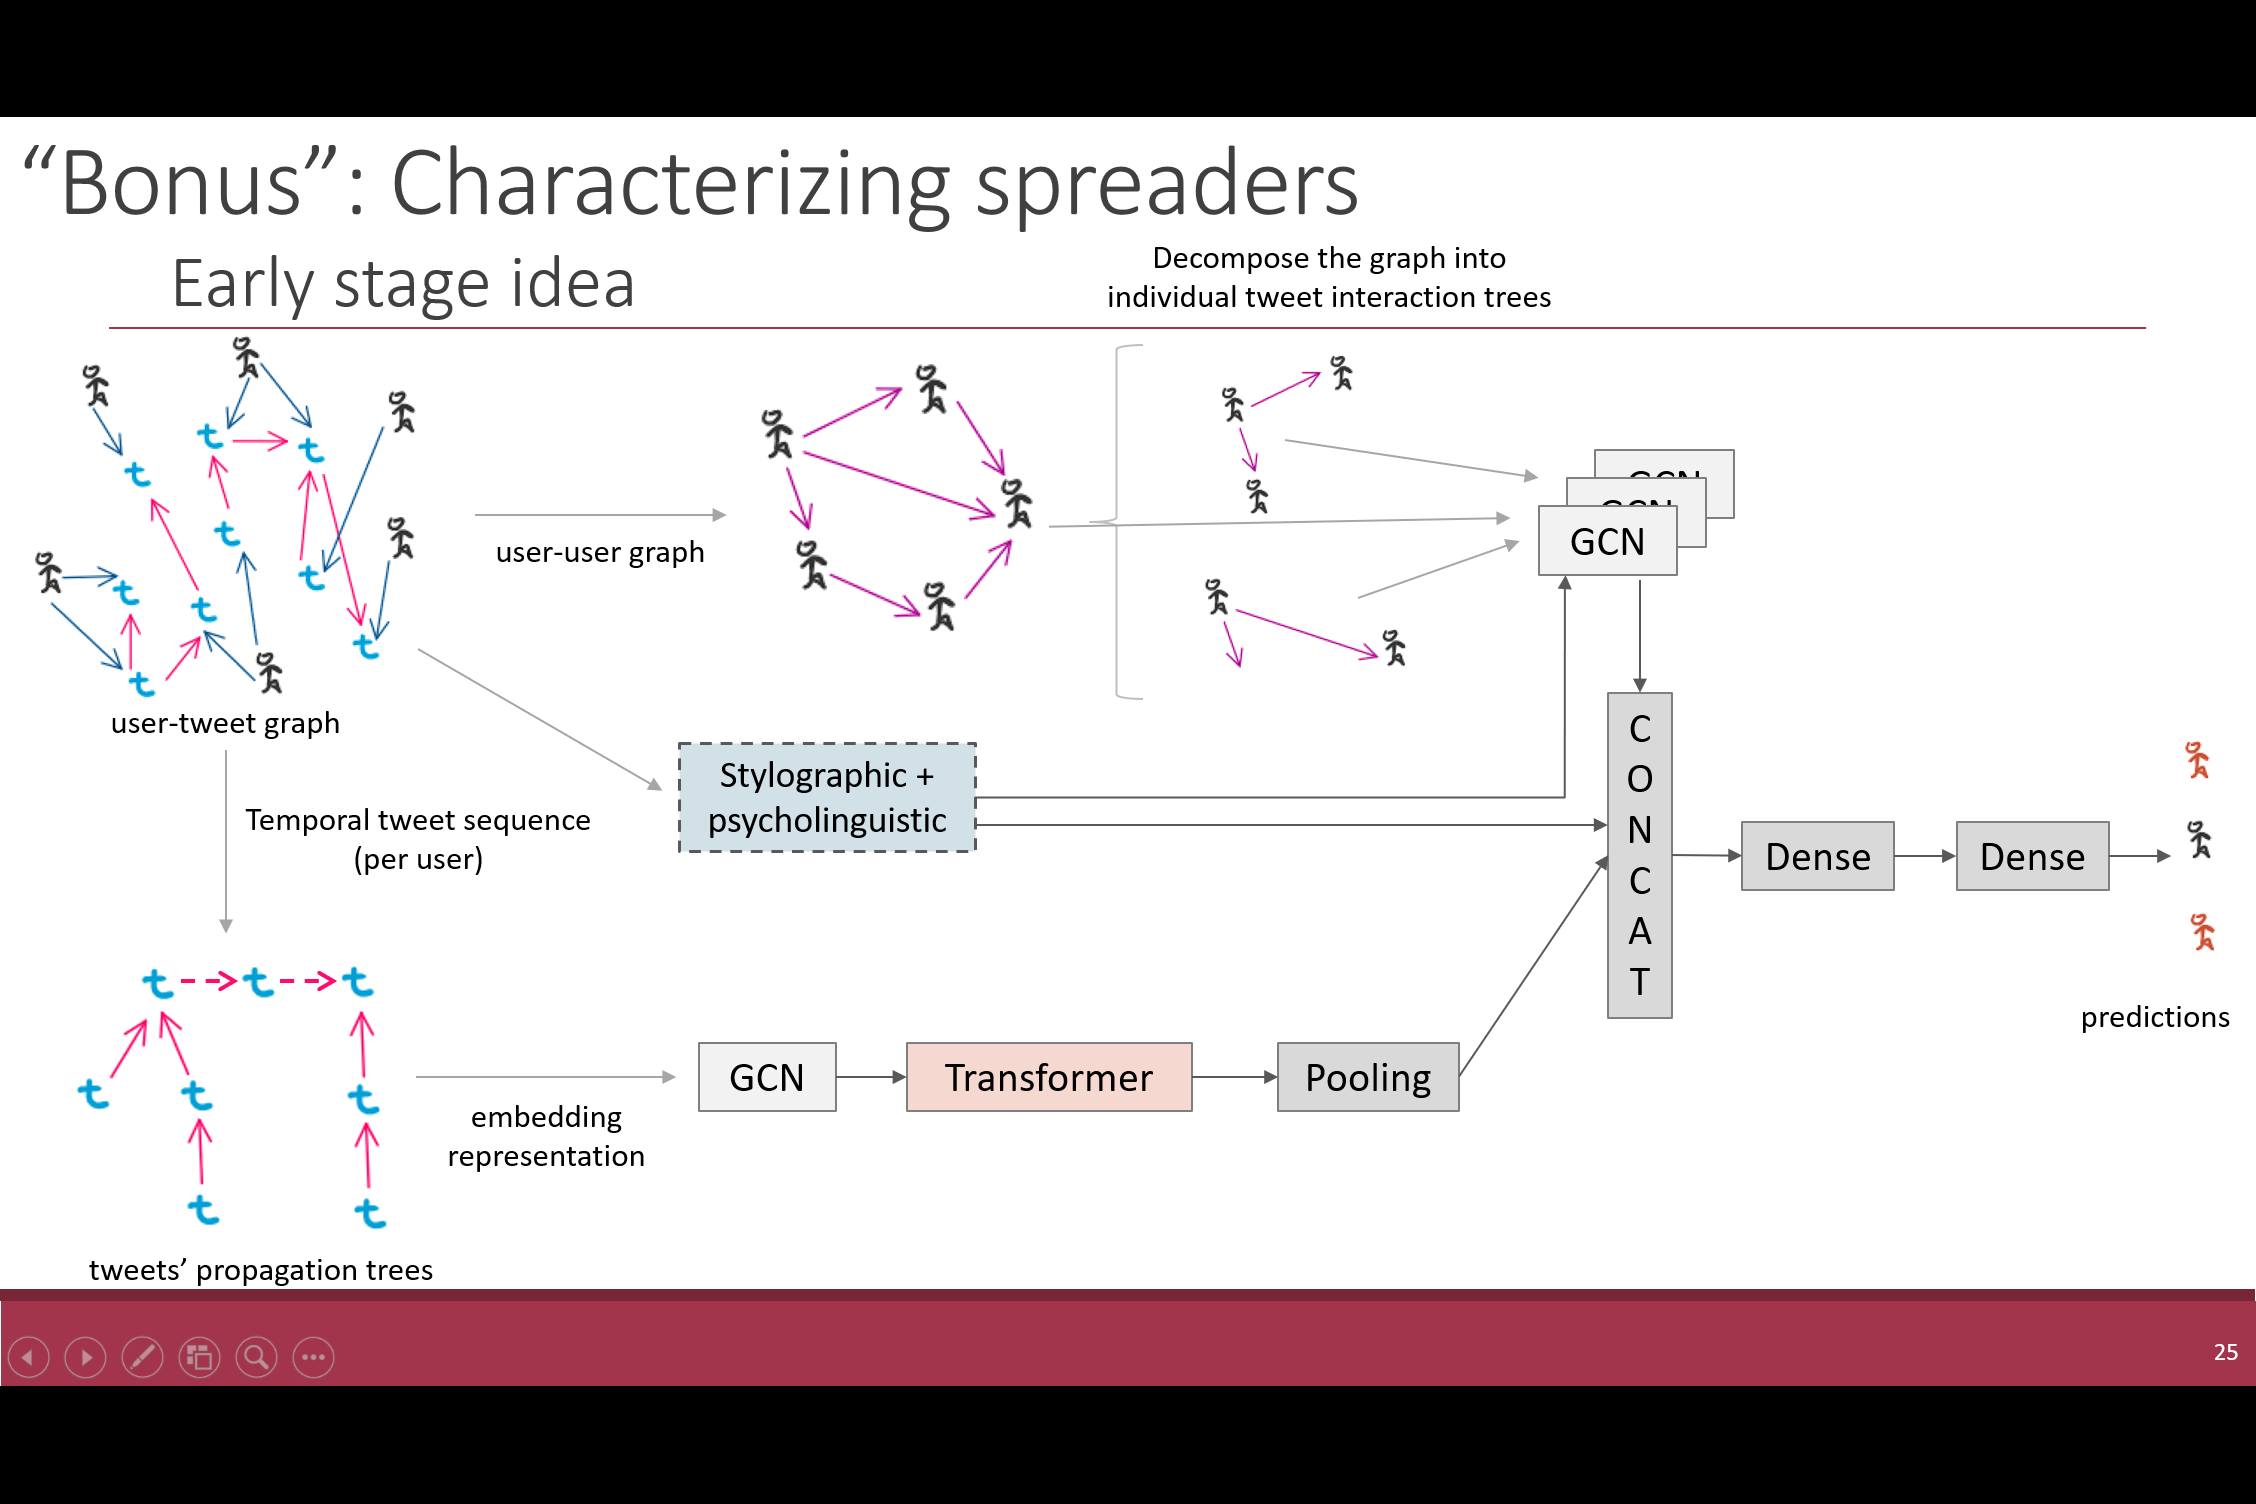](attachment:image.png)
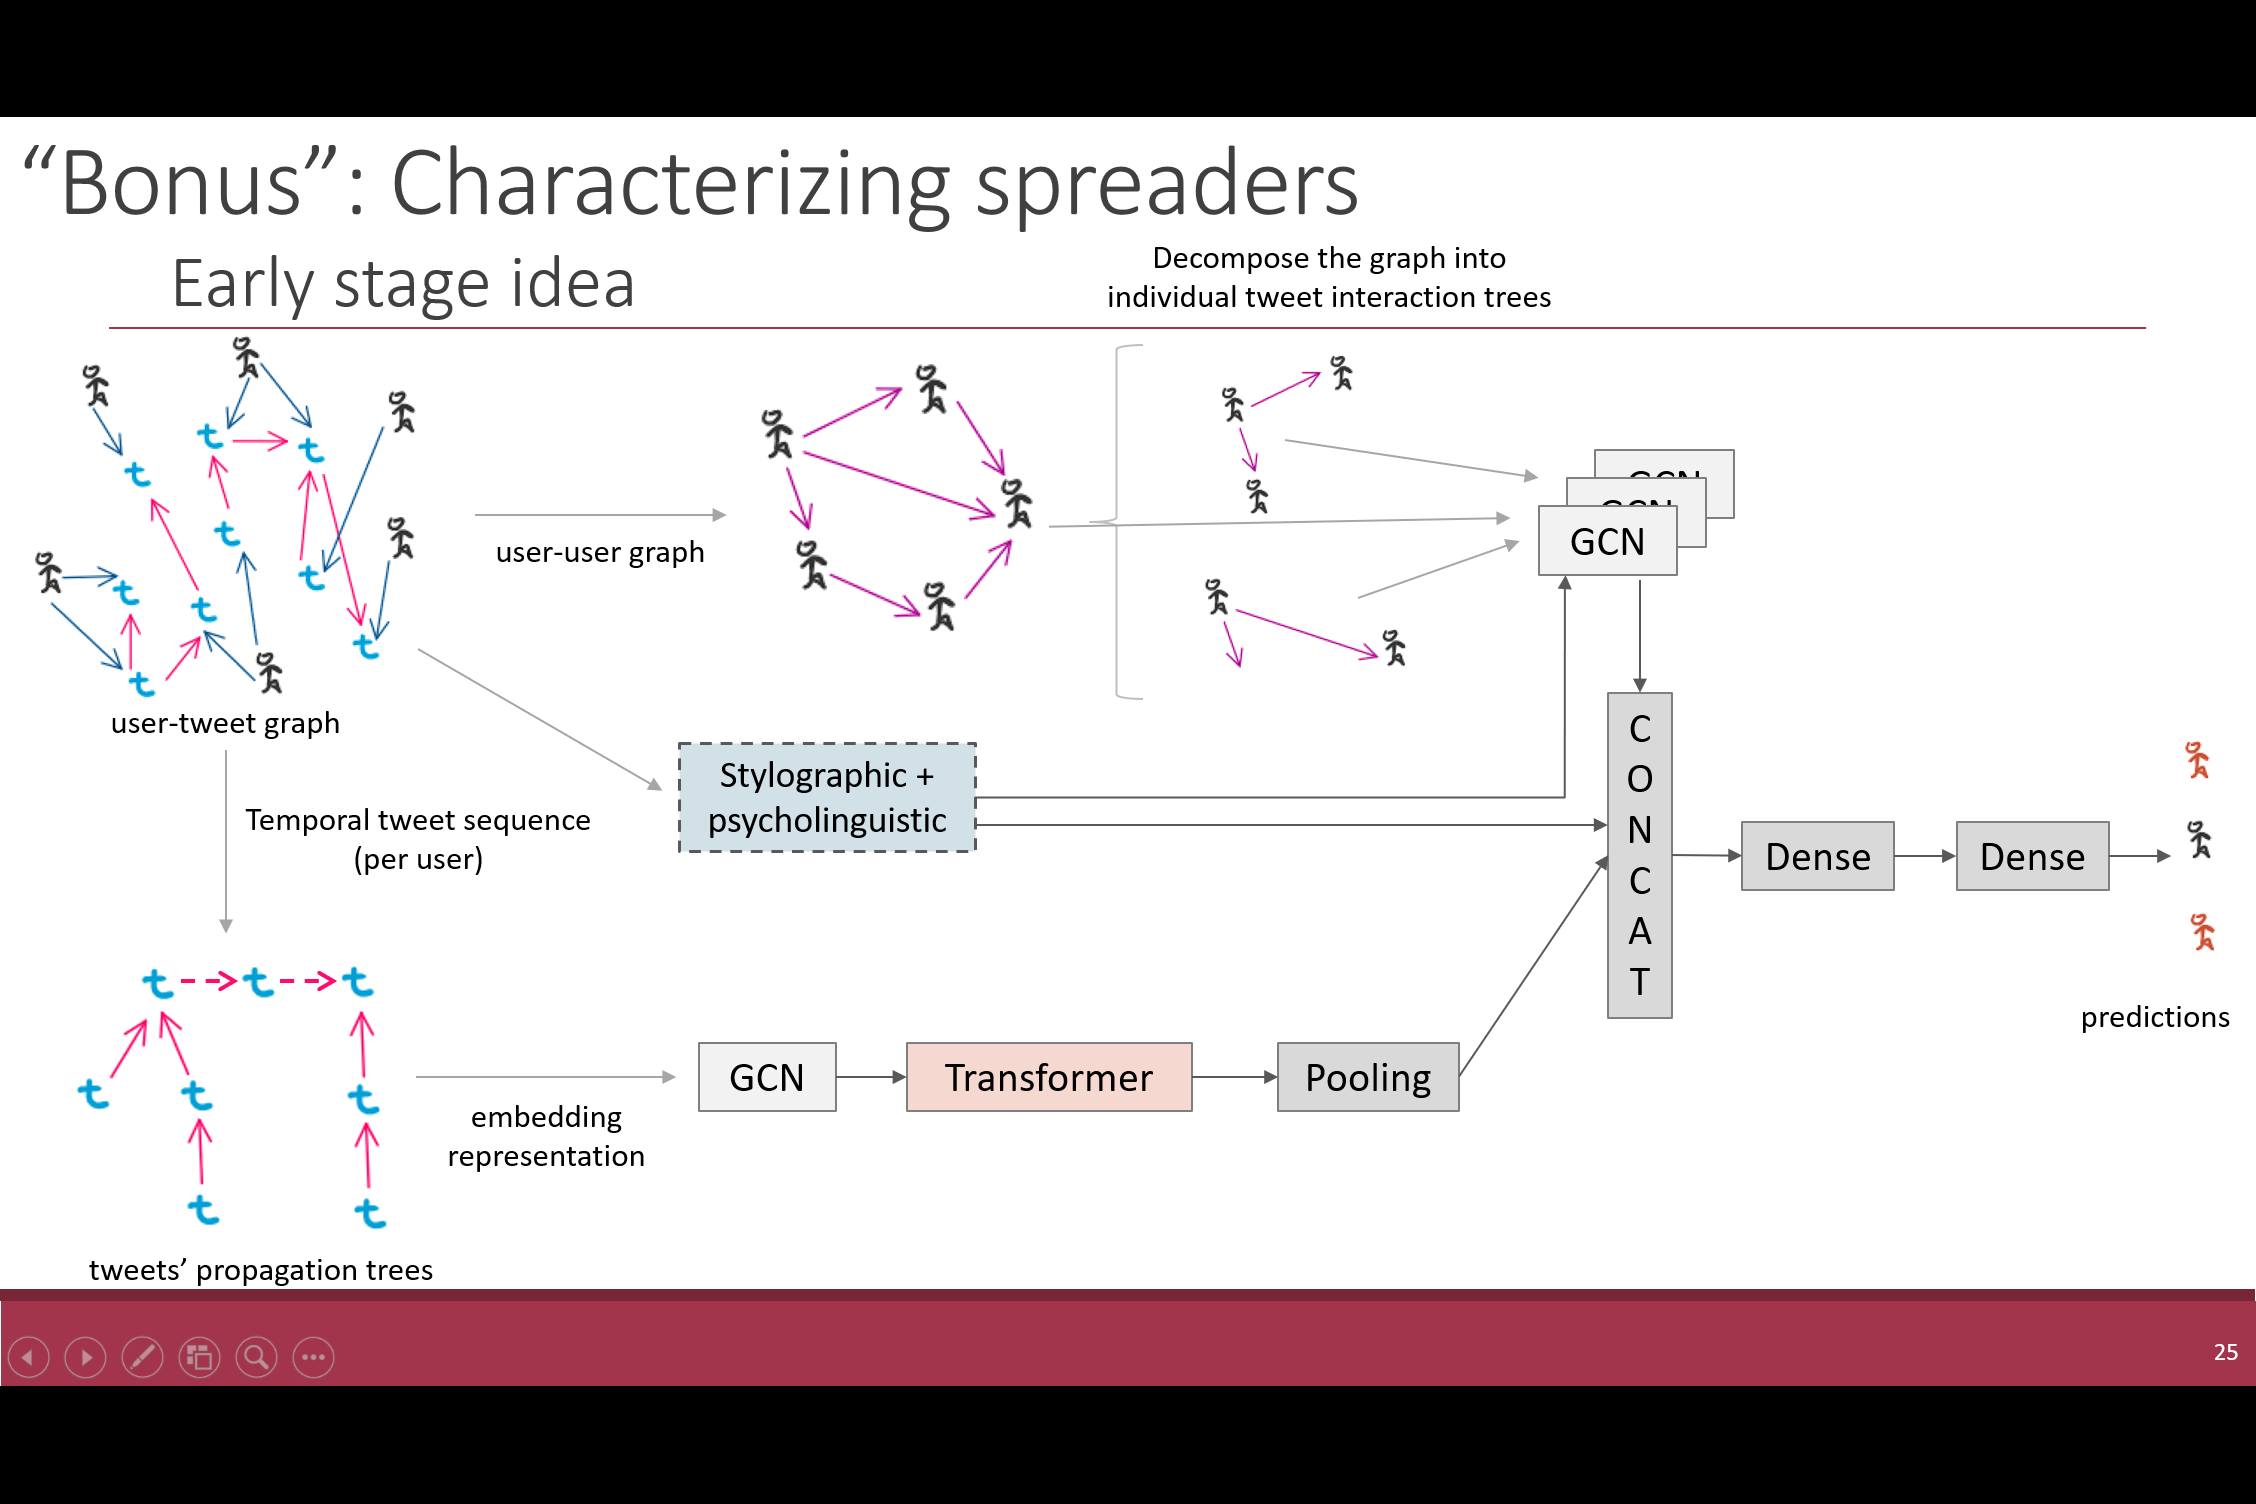

In [9]:
class SpreaderPerdictor(torch.nn.Module):
    """
    :user_features: number of features for the user
    :gcn_users: list of the units for user GCNs
    :gcn_tweets: list of the units for user GCNs
    :q_k_v: size of the query, key and value vector for the transforme
    :att_heads: number of attentions heads
    :att_emb: embeddings size
    :dense: list of size for the last dense/linear layers
    """
    def __init__(self, user_features, gcn_users, gcn_tweets, att_heads, att_emb, dense, sigmoid=True):
        super().__init__()
        self.gcn_users = []
        prev_features = user_features
        for units in gcn_users:
            self.gcn_users.append(GCN(prev_features, units))
            prev_features = units
        self.gcn_users = torch.nn.ModuleList(self.gcn_users)
        #Tweet Part
        self.gcn_tweets = []
        prev_features = 768 #bert size
        for units in gcn_tweets:
            self.gcn_tweets.append(GCN(prev_features, units))
            prev_features = units
        self.gcn_tweets = torch.nn.ModuleList(self.gcn_tweets)
        self.query = torch.nn.Linear(prev_features, att_emb)
        self.key = torch.nn.Linear(prev_features, att_emb)
        self.value = torch.nn.Linear(prev_features, att_emb)
        self.multiheadattention = torch.nn.MultiheadAttention(att_emb, att_heads)
        #Dense Part
        prev_features = user_features + gcn_users[-1] + att_emb
        self.dense = []
        for v in dense:
            self.dense.append(torch.nn.Linear(prev_features, v))
            prev_features = v
        self.dense = torch.nn.ModuleList(self.dense)  
        self.pred = torch.nn.Linear(prev_features, 1)
        self.sigmoid = sigmoid
        pass
    
    def forward(self, user_graph, user_features, user_tweets, tweet_graph, tweet_bert):
        #GCN users
        c_user_features = user_features
        for gcn_u in self.gcn_users:
            c_user_features = gcn_u(c_user_features, user_graph)
            c_user_features = relu(c_user_features)
        #Saco solo las features del usuario actual que seria el primero
        c_user_features = c_user_features[:, 0, :]  #batch_size, user_graph[-1]
        #return c_user_features
        #Ahora los tweets
        c_tweet_features = tweet_bert
        for gcn_t in self.gcn_tweets:
            c_tweet_features = gcn_t(c_tweet_features, tweet_graph)
            c_tweet_features = relu(c_tweet_features)
        part_tweets = []
        for i, l in enumerate(user_tweets):
            #Extract the tweets original from the user. tweets by features
            #then it transforms into a 1 by tweets by features to be processed by attenstion
            p_tweet = c_tweet_features[i, :l, :][None, ...]
            p_tweet_q = self.query(p_tweet)
            p_tweet_k = self.key(p_tweet)
            p_tweet_v = self.value(p_tweet)
            p_tweet, _ = self.multiheadattention(p_tweet_q, p_tweet_k, p_tweet_v)
            #Max_pool
            p_tweet, _ = torch.max(p_tweet, dim=1)
            part_tweets.append(p_tweet)
        part_tweets = torch.stack(part_tweets, dim=0)[:, 0, :]
        #Concat
        full_data = torch.concat([c_user_features, user_features[:, 0, :], part_tweets], dim=1)
        for dense in self.dense:
            full_data = dense(full_data)
            full_data = relu(full_data)
        full_data = self.pred(full_data)
        if self.sigmoid:
            full_data = torch.sigmoid(full_data)
        return full_data

In [10]:
def has_nans(d):
    for k, v in d.items():
        v = v.detach().cpu().numpy()
        if not (v == v).all():
            print(k)

def train(model, device, train, optimizer, loss_fuction, epochs, weights, checkpoint=None):
    for e in range(1, epochs + 1):
        print(f'Epoch {e} of {epochs}')
        tbar = tqdm(train)
        losses = 0
        cant = 0
        for x, y in tbar:
            optimizer.zero_grad()
            x_proc = {}
            for k in ['user_graph', 'user_features', 'tweet_graph', 'tweet_bert']:
                x_proc[k] = x[k].to(device)
            y_proc = y.to(device)
            # Make the predictions
            pred = model(**x_proc, user_tweets=x['tweet_len'])
            # Calculate loss
            weight = weights[torch.where(y_proc[:, 0].long() > 0, 1, 0)]
            loss = loss_fuction(pred, y_proc)
            loss = torch.mean(weight * loss)
            # Calculate the gradients
            loss.backward()
            # Optimize
            optimizer.step()
            # Update print information
            losses += loss.item()
            cant += 1
            tbar.set_postfix(loss=(losses / cant))
        loss = {losses / cant}
        print(f'Final average loss {loss}')
        if checkpoint is not None:
            checkpoint(model=model, epoch=e, loss=loss)
    pass

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HingeLoss:
    def __init__(self, margin=1, device=device):
        self.margin = torch.scalar_tensor(margin, dtype=torch.float32, device=device)
        self.zero = torch.scalar_tensor(0, dtype=torch.float32, device=device)

    def __call__(self, pred, true):
        res = self.margin - pred * true
        res = torch.where(res >= self.zero, res, self.zero)
        return res

def checkpoint(model, epoch, loss, partition):
    model_dir = f'models_0.5_hinge_relu_small_{partition}'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = f'{model_dir}{os.sep}model-epoch_{epoch}.pt'
    torch.save(model.state_dict(), model_path)

In [12]:
def preprocess(df, users):
    train_df = df.loc[users]
    #Columnas con un valor
    one_value_columns = []
    for c in train_df.columns:
        f_value = train_df[c].iloc[0]
        if (train_df[c] == f_value).all():
            one_value_columns.append(c)
    train_df = train_df.drop(one_value_columns, axis=1)
    print(f'Removing columns with one value {one_value_columns}')
    valid_columns = []
    for c in train_df.columns:
        column = train_df[c]
        if -1 <= min(column) and max(column) <= 1:
            valid_columns.append(c)
    print(f'Columns between 0 and 1 {valid_columns}')
    train_df_to_process = train_df.drop(valid_columns, axis=1)
    train_df = train_df[valid_columns]
    #Scalando valores
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_df_to_process)
    #Procesando
    df = df.drop(one_value_columns, axis=1)
    df_freeze = df[valid_columns]
    df_freeze = df_freeze.astype(np.float32)
    df_process = df.drop(valid_columns, axis=1)
    index = df_process.index
    df_process = scaler.transform(df_process)
    df_process = pd.DataFrame(data=np.clip(df_process, -2, 2), 
                              columns=train_df_to_process.columns,
                              index=index)
    df = pd.concat([df_freeze, df_process], axis=1)
    return df


def train_for_partition(partition):
    checkpoint_p = partial(checkpoint, partition=partition)
    
    user_features_preprocessed = preprocess(user_features, list(user_partitions[partition][0]))
    ds = UserDataset(train_graph, tweet_graph, user_partitions[partition][0],
                     user_features_preprocessed, inverted_graph=False, max_depth_user=3, threshold=0.5)
    dl = torch.utils.data.DataLoader(ds, batch_size=10, collate_fn=merge_dataset_instances, num_workers=0, shuffle=True)
    
    classes = np.asarray([1 if ds.user_graph.nodes[node]['score_graph'] > ds.threshold else 0 for node in ds.users])
    weights = compute_class_weight('balanced', classes=[0, 1], y=classes)
    print(weights)
    print(classes.tolist().count(0))
    print(classes.tolist().count(1))
    
    weights = torch.from_numpy(np.asarray(weights)).float().to(device)
    model = SpreaderPerdictor(len(user_features.columns), [32, 32, 32], [100], 2, 30, [70, 70], sigmoid=False)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss = HingeLoss()

    train(model, device, dl, optimizer, loss, 20, weights, checkpoint_p)

In [13]:
train_for_partition(0)

Removing columns with one value []
Columns between 0 and 1 ['user_stats_is_verified', 'user_stats_has_defatult_picture', 'liwc_auxverb', 'liwc_focuspresent', 'liwc_pronoun', 'liwc_ppron', 'liwc_you', 'liwc_social', 'liwc_cogproc', 'liwc_insight', 'liwc_verb', 'liwc_tentat', 'liwc_drives', 'liwc_achiev', 'liwc_prep', 'liwc_bio', 'liwc_ingest', 'liwc_leisure', 'liwc_article', 'liwc_conj', 'liwc_relativ', 'liwc_time', 'liwc_motion', 'liwc_ipron', 'liwc_adj', 'liwc_affect', 'liwc_posemo', 'liwc_i', 'liwc_adverb', 'liwc_differ', 'liwc_discrep', 'liwc_affiliation', 'liwc_death', 'liwc_compare', 'liwc_quant', 'liwc_number', 'liwc_space', 'liwc_negate', 'liwc_focuspast', 'liwc_reward', 'liwc_work', 'liwc_power', 'liwc_negemo', 'liwc_anger', 'liwc_certain', 'liwc_sad', 'liwc_informal', 'liwc_netspeak', 'liwc_percept', 'liwc_hear', 'liwc_they', 'liwc_nonflu', 'liwc_assent', 'liwc_see', 'liwc_interrog', 'liwc_risk', 'liwc_friend', 'liwc_male', 'liwc_female', 'liwc_family', 'liwc_cause', 'liwc_anx

  0%|          | 0/14816 [00:00<?, ?it/s]

[0.8216504  1.27724138]
9016
5800
Epoch 1 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.5964998738908092}
Epoch 2 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.4745304833154361}
Epoch 3 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.43845104466793217}
Epoch 4 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.41423370141108856}
Epoch 5 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.40095914768116364}
Epoch 6 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.39119466867087427}
Epoch 7 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.3827513802311185}
Epoch 8 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.37422079077636505}
Epoch 9 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.37084878642464736}
Epoch 10 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.371577463080231}
Epoch 11 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.3585687674644729}
Epoch 12 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.3574336905618705}
Epoch 13 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.3463022767413909}
Epoch 14 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.34737888248499166}
Epoch 15 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.33852810451677023}
Epoch 16 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.3333450743200995}
Epoch 17 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.33431935670427015}
Epoch 18 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.32379095555770077}
Epoch 19 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.32099608985682654}
Epoch 20 of 20


  0%|          | 0/1482 [00:00<?, ?it/s]

Final average loss {0.3166845780056353}
